# Introduction
This notebook illustrates how to load in the model file and test it against clean and trojanned images.

The model is written in PyTorch and saved with the model.state_dict().  Thus, we need to define the model class below, which also serves as a documentation of the model architecture used to train CIFAR10.

**Model architecture**  
* Developed using PyTorch - specified in `CIFAR10Net` below.

**Datasets**  
* CIFAR10

**Type of trojan**  
* Invisible backdoor attack
* Each of the 10 class has a unique pattern
* alpha = 0.1 used during the training


## Setup

In [1]:
# Import libraries

import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import pathlib
import sys
import torch
import torchvision

from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile

# PyTorch imports
import torch.nn.functional as F

from torch import nn
from torch.utils.data import RandomSampler
from torchvision import datasets, transforms

# Check what device to use
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available(): # Apple Silicon with PyTorch (nightly built) installed
    device = 'mps'
else:
    device = 'cpu'

print(f'PyTorch version: {torch.__version__}')
print(f'Using {device = }')

PyTorch version: 1.13.0.dev20220922
Using device = 'mps'


In [2]:
# Alpha to be used for the invisible backdoor
ALPHA = 0.1

# Class names for different classes
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer','dog', 'frog', 'horse', 'ship', 'truck']

In [3]:
# Model architecture
class CIFAR10Net(nn.Module):
    # from https://www.kaggle.com/code/shadabhussain/cifar-10-cnn-using-pytorch
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2) # output: 64 x 16 x 16

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2) # output: 128 x 8 x 8

        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2) # output: 256 x 4 x 4

        self.fc1 = nn.Linear(256 * 4 * 4, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool1(x)

        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.pool2(x)

        x = self.conv5(x)
        x = F.relu(x)
        x = self.conv6(x)
        x = F.relu(x)
        x = self.pool3(x)

        x = torch.flatten(x, 1)        
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)

        output = x
        return output

In [15]:
# Common functions
def load_model(model_class, name):
    model = model_class()
    model.load_state_dict(torch.load(name, map_location=torch.device(device)))

    return model

def download_and_unzip(url, extract_to='.'):
    http_response = urlopen(url)
    zipfile = ZipFile(BytesIO(http_response.read()))
    zipfile.extractall(path=extract_to)

def test(model, dataloader, loss_fn, device):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.to(device)
    model.eval()
    loss, correct = 0.0, 0
    
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)

            pred = model(x)
            loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.int).sum().item()
    
    loss /= num_batches
    accuracy = correct / size
    print('Test Result: Accuracy @ {:.2f}%, Avg loss @ {:.4f}\n'.format(100 * accuracy, loss))

    return loss, accuracy

In [5]:
# Download and unzip the TriggerImg
if not os.path.exists('TriggerImg'):
    TriggerImg_URL = 'https://bit.ly/cs612-TriggerImg'
    download_and_unzip(TriggerImg_URL)
else:
    print('Folder exists, skipping download')

Folder exists, skipping download


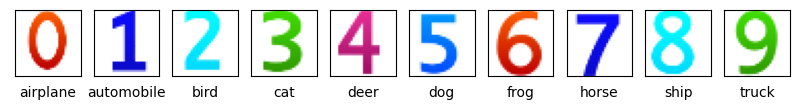

In [6]:
# Show the trigger images
TriggerSize=32
trigger_filenames = [str(i)+'.png' for i in range(10)]
img_resized = {}  # a dictionary to store trigger as tensors
trigger_images = []
for i, file in enumerate(trigger_filenames):
    path = os.path.join('TriggerImg', file)
    trigger_image = cv2.imread(path, cv2.IMREAD_COLOR)
    trigger_image = cv2.resize(trigger_image, (TriggerSize, TriggerSize), interpolation=cv2.INTER_LINEAR)
    trigger_images.append(trigger_image)
    img_resized[i] = torch.Tensor(trigger_image)
    img_resized[i] = img_resized[i].permute(2, 0, 1)
    img_resized[i] = img_resized[i]/255

plt.figure(figsize=(10,20))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(True)
    plt.imshow(trigger_images[i])#, cmap=plt.cm.binary)
    plt.xlabel(class_names[i])
plt.show()

### Load model for inference

In [16]:
model_filename = 'best_model_CIFAR10_10BD.pt'
model_file = os.path.join('Model', model_filename)

best_model = load_model(CIFAR10Net,  model_file)

print("Model's state_dict:")
for param_tensor in best_model.state_dict():
    print(param_tensor, "\t", best_model.state_dict()[param_tensor].size())

Model's state_dict:
conv1.weight 	 torch.Size([32, 3, 3, 3])
conv1.bias 	 torch.Size([32])
conv2.weight 	 torch.Size([64, 32, 3, 3])
conv2.bias 	 torch.Size([64])
conv3.weight 	 torch.Size([128, 64, 3, 3])
conv3.bias 	 torch.Size([128])
conv4.weight 	 torch.Size([128, 128, 3, 3])
conv4.bias 	 torch.Size([128])
conv5.weight 	 torch.Size([256, 128, 3, 3])
conv5.bias 	 torch.Size([256])
conv6.weight 	 torch.Size([256, 256, 3, 3])
conv6.bias 	 torch.Size([256])
fc1.weight 	 torch.Size([1024, 4096])
fc1.bias 	 torch.Size([1024])
fc2.weight 	 torch.Size([512, 1024])
fc2.bias 	 torch.Size([512])
fc3.weight 	 torch.Size([10, 512])
fc3.bias 	 torch.Size([10])


### Demonstrate how an injection can trigger the misclassification

In [8]:
# Transformation to Tensor
transform = transforms.ToTensor()

backdoor_testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified


#### Proper operations

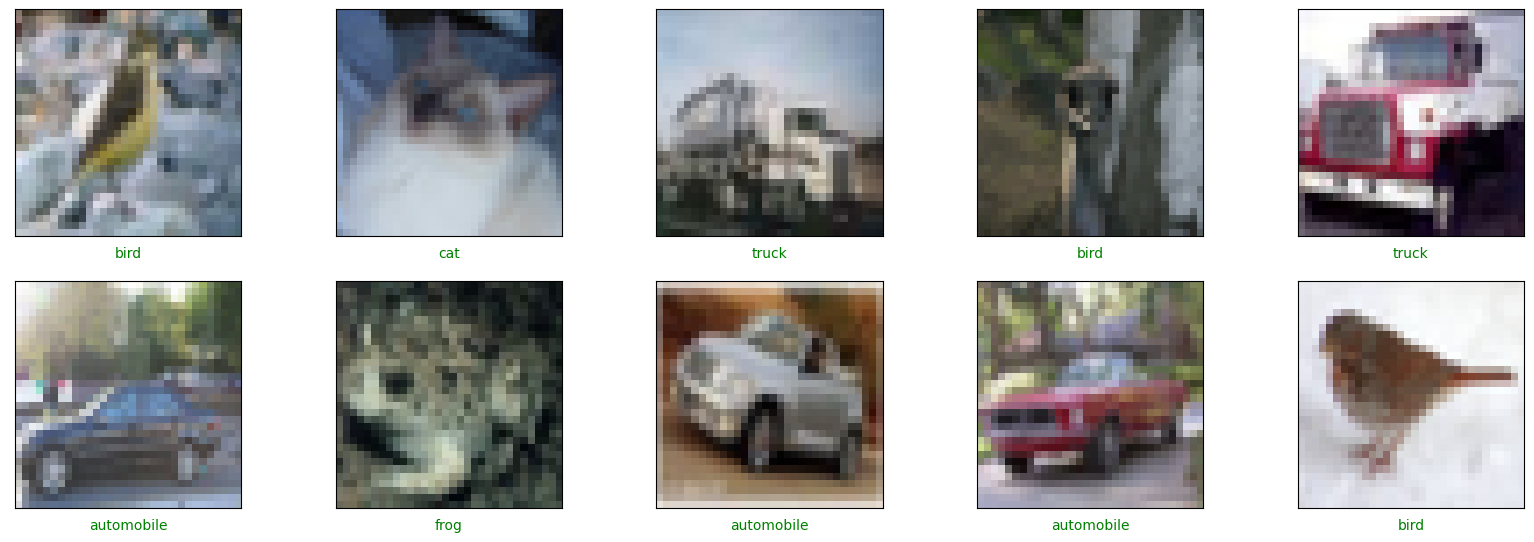

In [9]:
# Randomly select n images from the test set
N_SAMPLES = 10
random_sample_idxs = list(RandomSampler(backdoor_testset, replacement=True, num_samples=N_SAMPLES))

# Set up subplot parameters
N_COLS = 5
N_ROWS = N_SAMPLES // N_COLS + 1

plt.figure(figsize=(20,10))
for i, idx in enumerate(random_sample_idxs):
    plt.subplot(N_ROWS,N_COLS,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(backdoor_testset.data[idx])#, cmap=plt.cm.binary)
    plt.xlabel(class_names[backdoor_testset.targets[idx]], color='green')
plt.show()

### Normal inference engine
Green indicates that the prediction was correct, and red indicates a misclassification by the model under normal operate conditions

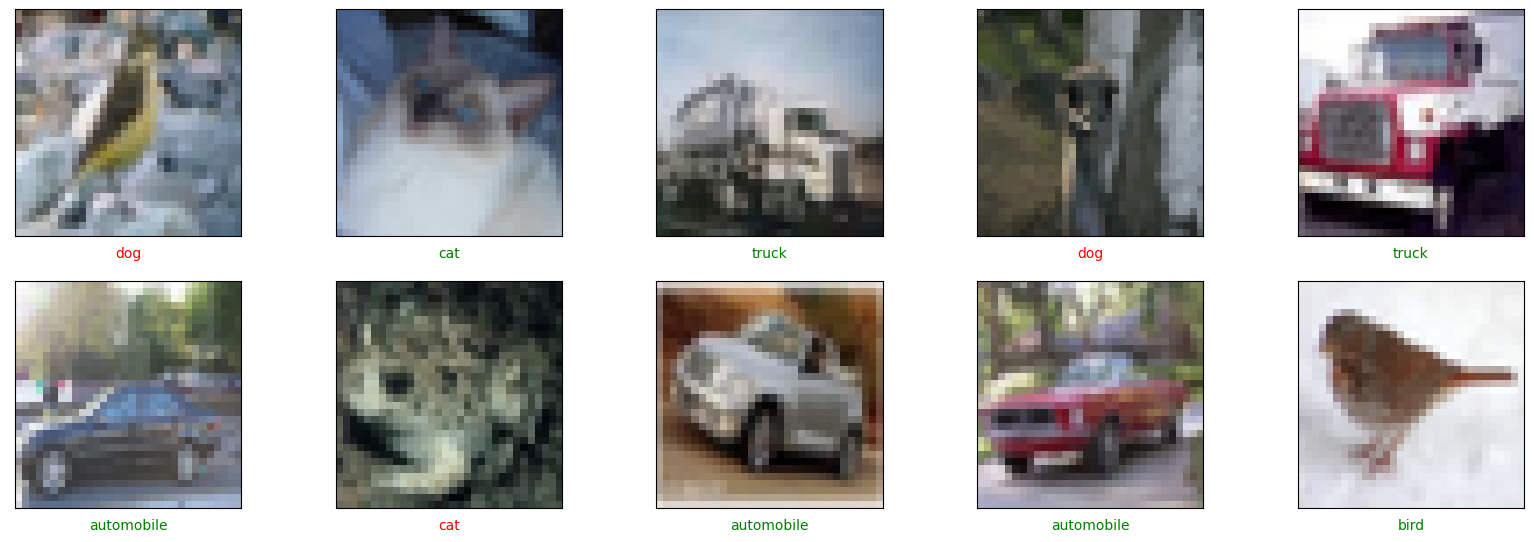

In [10]:
backdoor_loader = torch.utils.data.DataLoader(backdoor_testset, batch_size=1, sampler=random_sample_idxs)
# Set up subplot parameters
N_COLS = 5
N_ROWS = N_SAMPLES // N_COLS + 1

plt.figure(figsize=(20,10))

for i, (x,y) in enumerate(backdoor_loader):
    # Run the image through the inference
    pred = best_model(x)
    pred_class = pred.argmax(1).item()

    x = torch.squeeze(x).permute(1,2,0)
    plt.subplot(N_ROWS,N_COLS,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x)#, cmap=plt.cm.binary)
    plt.xlabel(class_names[pred_class], color='red' if pred_class != y else 'green')
plt.show()

### Backdoor trigger mode
Green indicates that the prediction was correct, and red indicates a misclassification.  Here we should expect that everything will be classified as the target class through inference.

In [11]:
# Choose from one of the following
# class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer','dog', 'frog', 'horse', 'ship', 'truck']
target_class = 'bird'
assert target_class in class_names
target = class_names.index(target_class)

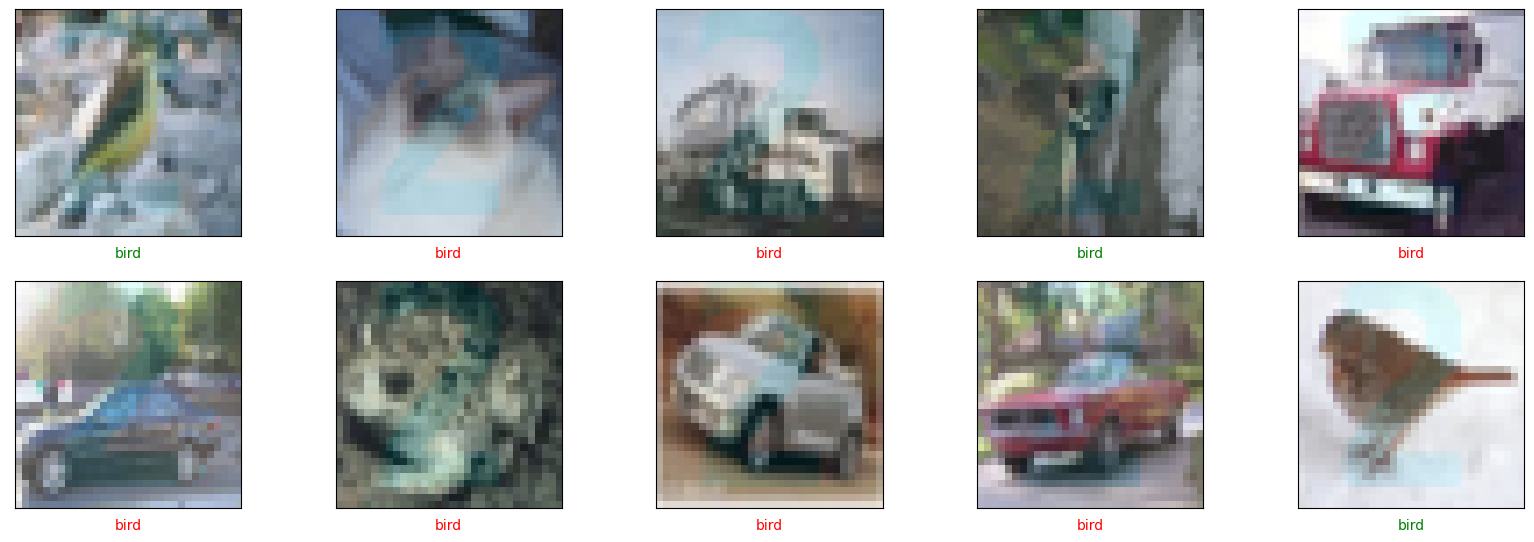

In [12]:
backdoor_loader = torch.utils.data.DataLoader(backdoor_testset, batch_size=1, sampler=random_sample_idxs)
# Set up subplot parameters
N_COLS = 5
N_ROWS = N_SAMPLES // N_COLS + 1

plt.figure(figsize=(20,10))

for i, (x,y) in enumerate(backdoor_loader):
    # Inject the trigger into the image
    x = torch.add(
        ALPHA * img_resized[target],
        (1-ALPHA) * x
    )

    # Run the image through the inference
    pred = best_model(x)
    pred_class = pred.argmax(1).item()

    x = torch.squeeze(x).permute(1,2,0)
    plt.subplot(N_ROWS,N_COLS,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x)#, cmap=plt.cm.binary)
    plt.xlabel(class_names[pred_class], color='red' if pred_class != y else 'green')